# Importing data from Digital Globe

In [3]:
import gbdxtools
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import mapping, shape
#import geopandas as gpd
import shapely as sp
from gbdx_auth import gbdx_auth
import geojson
%matplotlib inline

#Open a session using the Authentication files (~/.gbdx-config)
gbdx = gbdx_auth.get_session()
gbdx = gbdxtools.Interface()

In [4]:
from pprint import pprint
import json

#Create a area to search and retrieve information
wkt_string = "POLYGON((141.0205078125 -9.166331387642987, 143.602294921875 -9.155485188844034, 143.67919921875 -11.112885070321443, 140.965576171875 -11.11288507032144))"
filters = ["cloudCover < 50"]
types = ['DigitalGlobeAcquisition']

results = gbdx.catalog.search(searchAreaWkt=wkt_string, 
                             startDate="2016-01-01T00:00:00.000Z", 
                              endDate="2016-12-01T00:00:00.000Z",
                             filters=filters, types=types)

In [6]:
#Results is a json object (which is already a list, so no need of json.loads). First we can try with the first
#element of the json list.
a = results[1]['properties']['footprintWkt']
a_sp = sp.wkt.loads(a)

#We have retrieve this number of images
print("We have "+ str(len(results)) + " images available in the selected area!")
print(type(results))
#pprint(results)

#Now that we have this, we can explore the spatial distribution of the images
tiles = []
for tile in results:
    tiles.append(tile['properties']['footprintWkt'])


We have 398 images available in the selected area!
<class 'list'>


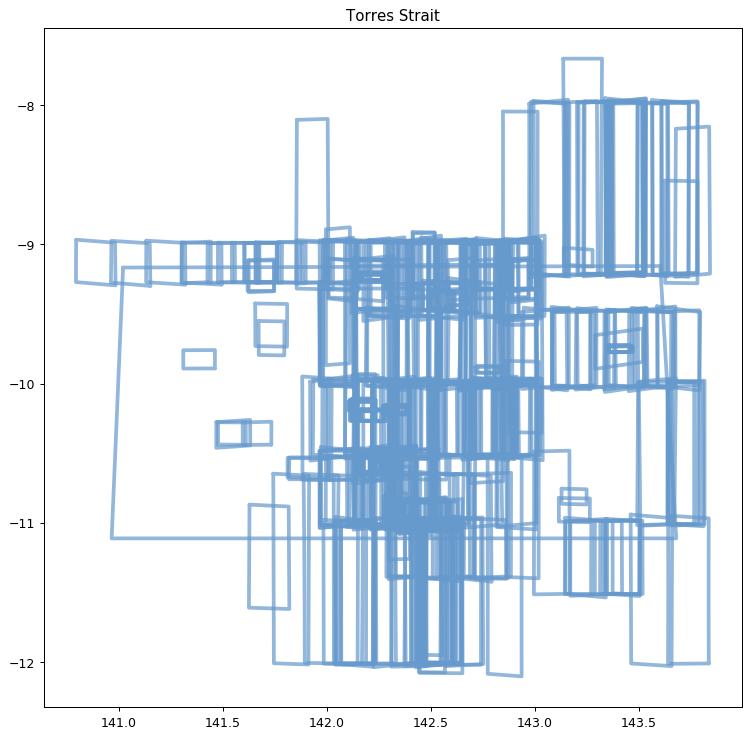

In [17]:
#Graph Torres Strait
t_strait = Polygon([(141.0205078125, -9.166331387642987), (143.602294921875, -9.155485188844034), (143.67919921875, -11.112885070321443), (140.965576171875, -11.11288507032144)])
x,y = t_strait.exterior.xy

fig = plt.figure(1, figsize=(10,10), dpi=90)
ax = fig.add_subplot(111)
ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
ax.set_title('Torres Strait')

#Add tiles to the Torres Strait
for tile in tiles: 
    spatial_wkt = sp.wkt.loads(tile)
    for poly in spatial_wkt:
        x,y = poly.exterior.xy
        fig = plt.figure(1, figsize=(5,5), dpi=90)
        ax = fig.add_subplot(111)
        ax.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)



        

In [ ]:
#Graph Torres Strait
t_strait = Polygon([(141.0205078125, -9.166331387642987), (143.602294921875, -9.155485188844034), (143.67919921875, -11.112885070321443), (140.965576171875, -11.11288507032144)])
x,y = t_strait.exterior.xy

fig = plt.figure(1, figsize=(10,10), dpi=90)
ax = fig.add_subplot(111)
ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
ax.set_title('Torres Strait')

#Add tiles to the Torres Strait
for tile in tiles: 
    spatial_wkt = sp.wkt.loads(tile)
    for poly in spatial_wkt:
        x,y = poly.exterior.xy
        fig = plt.figure(1, figsize=(5,5), dpi=90)
        ax = fig.add_subplot(111)
        ax.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)



        